# Sieci neuronowe i Deep Learning
# Temat 2: Adaline i metoda gradientu prostego

## Wczytanie zbioru danych Iris (analogicznie jak w poprzednim notebooku)

In [1]:
import os
import pandas as pd

try:
    s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    print('From URL:', s)
    df = pd.read_csv(s,
                     header=None,  # Plik nie zawiera wiersza nagłówkowego z nazwami kolumn
                     encoding='utf-8')  # Określa kodowanie znaków pliku
    
except HTTPError:
    s = 'iris.data'
    print('From local Iris path:', s)
    # Wczytanie danych z lokalnej ścieżki:
    df = pd.read_csv(s,
                     header=None,
                     encoding='utf-8')

From URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


In [ ]:
# W razie problemów z pobraniem danych z Internetu:
df = pd.read_csv('your/local/path/to/iris.data', header=None, encoding='utf-8')

Do analizy bierzemy pierwszych 100 przykładów (50 kwiatów typu Iris-setosa i 50 Iris-versicolor) i konwertujemy etykiety klas na `1` (versicolor) i `0` (setosa). Nowe etykiety zapisujemy w wektorze `y`.
Ponadto ekstrahujemy pierwszą kolumnę (długość kielicha) i trzecią kolumnę (długość płatka) z tych 100 przykładów treningowych i tworzymy z nich macierz cech `X`.

In [2]:
import numpy as np

# Wydzielamy dwa gatunki (setosa oraz versicolor):
y = df.iloc[0:100, 4].values  # Wybiera wiersze od 0 do 99 i 5-tą kolumnę
                              # Metoda .values konwertuje tę kolumnę na tablicę NumPy
y = np.where(y == 'Iris-setosa', 0, 1)

# Wydzielamy dwie cechy (sepal length oraz petal length):
X = df.iloc[0:100, [0, 2]].values

## Potrzebne funkcje z poprzedniego notebooka

In [3]:
# Poniższy kod przedstawia implementację funkcji,
# która wizualizuje granicę decyzyjną klasyfikatora dla dwuwymiarowej przestrzeni cech.

from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, resolution=0.02):  # resolution - rozmiar kroku siatki do wizualizacji przestrzeni

    # Definiujemy listy markerów i kolorów, które będą używane do reprezentowania różnych klas na wykresie:
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    # Tworzymy mapę kolorów ListedColormap na podstawie kolorów określonych w colors. 
    # cmap to obiekt, który Matplotlib używa do mapowania liczb na kolory
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # Wykres obszarów decyzyjnych:
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # Określamy zakresy wartości dla obu cech (-/+ 1)
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))  # Tworzymy dwuwymiarową siatkę punktów do wizualizacji przestrzeni cech
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)  # Liczymy predykcje dla każdego punktu siatki
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)  # Rysowanie konturu granic decyzyjnych
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())  # Ustawiono granice osi wykresu

    # Rysowanie przykładów z rozważanych klas:
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

## Implementacja metody Adaline w Pythonie

Wystarczy zmodyfikować kod do metody perceptronu tak, aby metoda `fit()` wykorzystywała technikę gradientu prostego do wyliczania wag (w wersji wsadowej - pełnej).

In [4]:
import numpy as np  # Wykorzystana do przekształceń z tablicami oraz do generowania liczb losowych

class AdalineGD:
    """ADAptive LInear NEuron classifier. (GD = Gradient Descent)

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        
        self.losses_ = []  # Zamiast self.errors_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # W przypadku Adaline funkcji activation() nie musimy tak naprawdę definiować,
            # ponieważ jest ona funkcją tożsamościową
            # (można by napisać wprost output = self.net_input(X)).
            # Definiujemy metodę activation jedynie dla uniwersalności kodu
            # (łatwo można np. przerobić go na regresję logistyczną, używając funkcji sigmoidalnej).
            output = self.activation(net_input)
            errors = (y - output)    
            
            # Można tak, ale byłoby mniej efektywnie:
            # for w_j in range(self.w_.shape[0]):
            #    self.w_[w_j] += self.eta * (2.0 * (X[:, w_j]*errors)).mean()
            
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)  # Zmiana na >= 0.5

Porównajmy zachowanie funkcji straty dla modelu Adaline (uczonego na podzbiorze zbioru Iris) po kolejnych epokach uczenia dla dwóch różnych wartości parametru $\eta$: $\eta = 0,1$ oraz $\eta = 0,0001$.

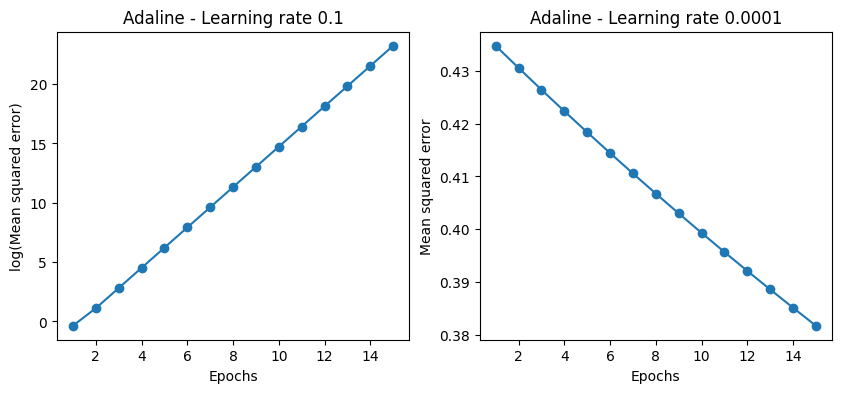

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean squared error)')
ax[0].set_title('Adaline - Learning rate 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean squared error')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

Lewy wykres: za duża wartość parametru uczenia, MSE rośnie przez kolejne epoki, przeskoczyliśmy przez globalne minimum.

Prawy wykres: strata maleje, ale w bardzo wolnym tempie (potrzebna bardzo duża liczba epok do osiągnięcia globalnego minimum funkcji straty).

## Skalowanie cech w kontekście metody gradientu prostego

In [6]:
# Standaryzacja cech (mean oraz std z NumPy):
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

Po standaryzacji budujemy kolejny model Adaline (tym razem z $\eta = 0,5$).

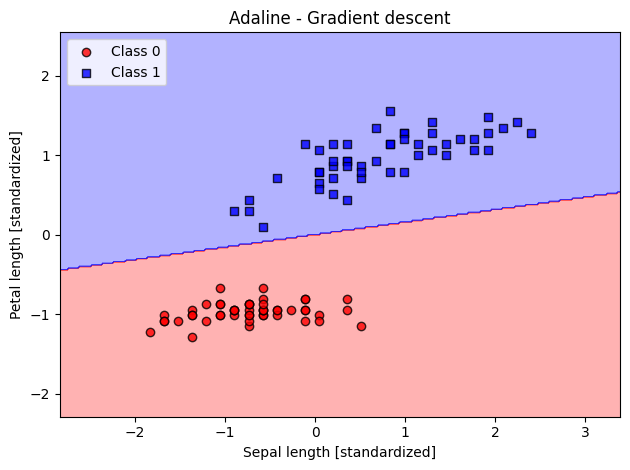

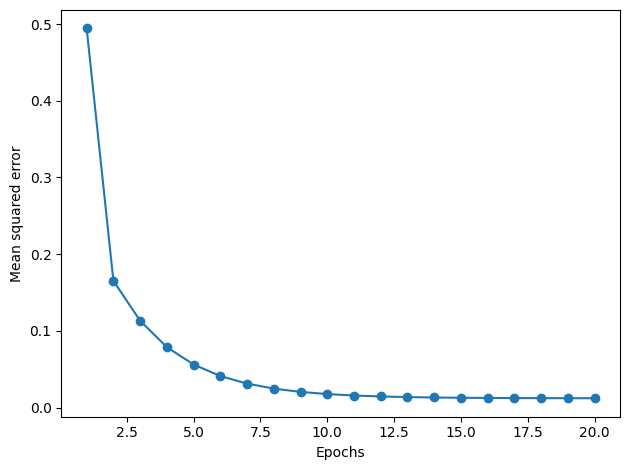

In [7]:
ada_gd = AdalineGD(n_iter= 20, eta=0.5)
ada_gd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean squared error')

plt.tight_layout()
plt.show()

## Metoda stochastycznego spadku wzdłuż gradientu (SGD)

Zmodyfikujemy kod implementujący metodę Adaline z wsadową wersją metody gradientu prostego tak, aby wykorzystywała algorytm stochastycznego spadku wzdłuż gradientu.

W ramach metody `fit` będziemy teraz aktualizowali wagi przykład po przykładzie.

Metoda `partial_fit` nie inicjalizuje wag na nowo (pozwala na aktualizację modelu z nowymi danymi bez potrzeby ponownego trenowania od zera).

Strata obliczana jest jako średnia strata dla wszystkich przykładów z danej epoki uczenia.

Metoda `_shuffle` umożliwia permutowanie danych uczących przed każdą epoką
(działa ona w ten sposób, że generowany jest różnowartościowy ciąg z liczb z zakresu 0:(rozmiar danych) i wykorzystywany jest on jako indeksy do mieszania zbioru uczącego).

In [8]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float_(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

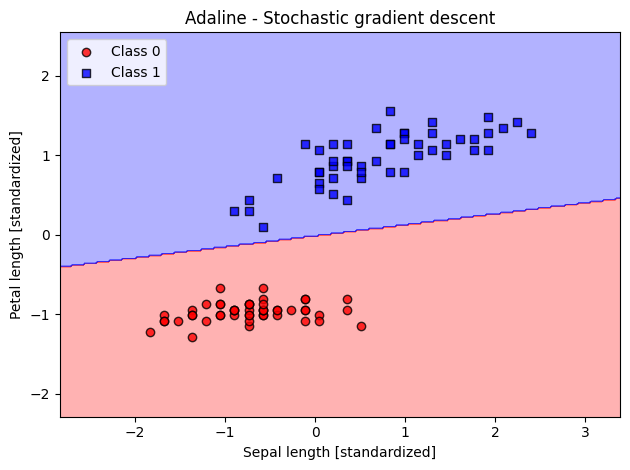

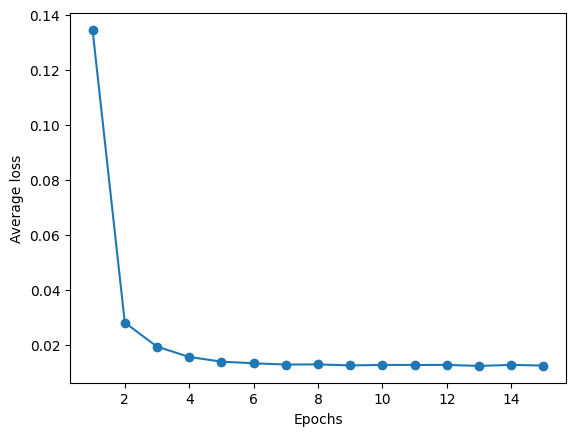

In [9]:
# Dopasowujemy model w wersji SGD do analizowanych danych Iris:

ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - Stochastic gradient descent')
plt.xlabel('Sepal length [standardized]')
plt.ylabel('Petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average loss')

plt.show()